<a href="https://colab.research.google.com/github/kthanikonda/Privacy-Aware-Computing/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install requests beautifulsoup4 pandas textstat selenium google-colab

!pkill chrome

!wget -q -O - https://dl-ssl.google.com/linux/linux_signing_key.pub | apt-key add -
!sh -c 'echo "deb [arch=amd64] http://dl.google.com/linux/chrome/deb/ stable main" >> /etc/apt/sources.list.d/google-chrome.list'
!apt-get update
!apt-get install -y google-chrome-stable

# Remove old ChromeDriver if it exists
!rm -f /usr/local/bin/chromedriver

# Download the latest ChromeDriver (ensure version compatibility)
!wget https://storage.googleapis.com/chrome-for-testing-public/133.0.6943.53/linux64/chromedriver-linux64.zip
!unzip -o chromedriver-linux64.zip
!chmod +x chromedriver-linux64/chromedriver
!mv chromedriver-linux64/chromedriver /usr/local/bin/chromedriver

# Check versions
!which google-chrome
!google-chrome --version
!chromedriver --version


OK
Get:1 http://dl.google.com/linux/chrome/deb stable InRelease [1,825 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://dl.google.com/linux/chrome/deb stable/main amd64 Packages [1,210 B]
Hit:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 3,035 B in 2s (1,719 B/s)
Reading package lists... Done
W: http://dl.google.com/linux/chrome/deb/dists/stable/InRelease: Key

In [ ]:
! pip install textstat
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import textstat
import random
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import time
from google.colab import files

# List of companies and their current privacy policy URLs
privacy_policies = {
    "Google": "https://policies.google.com/privacy",
    "LinkedIn": "https://www.linkedin.com/legal/privacy-policy",
}

# Function to fetch privacy policy text
def fetch_policy_text(url):
    options = Options()
    options.add_argument("--headless")  # Run browser in headless mode (without GUI)
    options.add_argument("--disable-gpu")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.binary_location = "/usr/bin/google-chrome-stable"  # Path for Chrome in Colab or modify accordingly

    # For local machine, use the path where you have ChromeDriver installed
    service = Service("/usr/local/bin/chromedriver")  # Path for ChromeDriver in Colab, modify for local machine

    driver = webdriver.Chrome(service=service, options=options)

    try:
        driver.get(url)
        time.sleep(5)  # Wait for the page to load

        last_height = driver.execute_script("return document.body.scrollHeight")
        while True:
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(2)
            new_height = driver.execute_script("return document.body.scrollHeight")
            if new_height == last_height:
                break
            last_height = new_height

        text = driver.find_element("tag name", "body").text
        return text
    except Exception as e:
        print(f"Error fetching {url}: {e}")
        return ""
    finally:
        driver.quit()

# Function to analyze readability
def readability_analysis(text):
    return {
        "Flesch Reading Ease": textstat.flesch_reading_ease(text),
        "Gunning Fog Index": textstat.gunning_fog(text),
        "SMOG Index": textstat.smog_index(text),
        "Complex Words %": (textstat.difficult_words(text) / max(len(text.split()), 1)) * 100
    }

# Function to calculate deception score
def calculate_deception_score(text):
    readability = readability_analysis(text)
    vague_words = ["may", "might", "could", "possibly", "sometimes", "often", "generally", "typically", "occasionally", "some"]
    vague_word_count = sum(text.lower().count(word) for word in vague_words)
    deception_score = (
        (100 - readability["Flesch Reading Ease"]) +
        readability["Gunning Fog Index"] +
        readability["Complex Words %"] +
        (vague_word_count * 5)  # Weight vague words in deception score
    ) / 4  # Average score
    return deception_score

# Function to modify sentences ensuring both positive and negative deception score changes
def modify_sentences(text):
    sentences = re.split(r'(?<=[.!?]) +', text)  # Split text into sentences
    selected_sentences = random.sample(sentences[:50], min(3, len(sentences)))  # Modify 3 random sentences

    modified_sentences = []
    for i, sentence in enumerate(selected_sentences):
        if i == 0:  # No change for the first sentence
            modified_sentence = sentence

        elif i == 1:  # Increase deception score (more vague, legal jargon)
            modified_sentence = (
                sentence.replace("may", "shall irrevocably and indisputably")
                .replace("possibly", "with absolute certainty")
                .replace("can", "must always, without exception")
                .replace("generally", "is universally mandated")
                .replace("ensure", "legally enforce to the fullest extent")
                .replace("consider", "mandate without discretion")
                .replace("often", "without deviation in all instances")
                .replace("protect", "categorically impose security measures")
                .replace("could", "is legally obligated to execute")
                .replace("review", "conduct in-depth regulatory assessment")
                .replace("use", "leverage with maximum discretion")
                .replace("access", "gain privileged access")
            )

        else:  # Decrease deception score (simpler & clearer)
            modified_sentence = (
                sentence.replace("will", "might sometimes")
                .replace("definitely", "could in some cases")
                .replace("must", "can optionally choose to")
                .replace("always", "occasionally when needed")
                .replace("strictly enforce", "recommend as a best practice")
                .replace("mandate without question", "suggest as a policy")
                .replace("without exception", "under most conditions but not all")
                .replace("permanently guarantee", "make efforts to ensure")
                .replace("is legally required to", "is encouraged to follow")
                .replace("thoroughly scrutinize", "review when necessary")
                .replace("authorized personnel", "employees")
                .replace("in compliance with", "in alignment with")
                .replace("subject to change", "may be updated periodically")
            )

        modified_sentences.append((sentence, modified_sentence))

    return modified_sentences

# Collect data
data = []

for company, url in privacy_policies.items():
    print(f"Processing {company}...")
    text_original = fetch_policy_text(url)

    if not text_original:
        print(f"Could not fetch privacy policy for {company}")
        continue

    modified_versions = modify_sentences(text_original)

    deception_original = calculate_deception_score(text_original)

    for i, (original_sentence, modified_sentence) in enumerate(modified_versions):
        text_modified = text_original.replace(original_sentence, modified_sentence)
        deception_modified = calculate_deception_score(text_modified)

        percentage_change = ((deception_modified - deception_original) / deception_original) * 100
        change_type = "Increase" if deception_modified > deception_original else "Decrease"

        data.append({
            "Company": company,
            "URL": url,
            "Original Sentence": original_sentence,
            "Modified Sentence": modified_sentence,
            "Original Deception Score": round(deception_original, 2),
            "Modified Deception Score": round(deception_modified, 2),
            "Percentage Change": f"{round(percentage_change, 2)}%",
            "Change Type": change_type,
            "Source": "Current Website"
        })

# Convert to DataFrame
df = pd.DataFrame(data)

# Save results to CSV
df.to_csv("privacy_policy_comparison.csv", index=False)

# Display DataFrame
from IPython.display import display
display(df)

# Download CSV file for Google Colab
files.download("privacy_policy_comparison.csv")


Processing Google...
Processing LinkedIn...


,Company,URL,Original Sentence,Modified Sentence,Original Deception Score,Modified Deception Score,Percentage Change,Change Type,Source
0,Google,https://policies.google.com/privacy,We understand this is a big responsibility and...,We understand this is a big responsibility and...,100.04,100.04,0.0%,Decrease,Current Website
1,Google,https://policies.google.com/privacy,"For example, depending on your available setti...","For example, depending on your available setti...",100.04,100.06,0.02%,Increase,Current Website
2,Google,https://policies.google.com/privacy,"And, depending on your available settings, Goo...","And, depending on your available settings, Goo...",100.04,100.04,0.0%,Decrease,Current Website
3,LinkedIn,https://www.linkedin.com/legal/privacy-policy,Data We Collect\n1.1 Data You Provide To Us\nY...,Data We Collect\n1.1 Data You Provide To Us\nY...,124.65,124.65,0.0%,Decrease,Current Website
4,LinkedIn,https://www.linkedin.com/legal/privacy-policy,"For example, we will get contact information f...","For example, we will get contact information f...",124.65,122.21,-1.96%,Decrease,Current Website
5,LinkedIn,https://www.linkedin.com/legal/privacy-policy,We will send invitation reminders to the perso...,We might sometimes send invitation reminders t...,124.65,128.40,3.01%,Increase,Current Website


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[==================================================] 100.0% 66.0/66.0MB downloaded


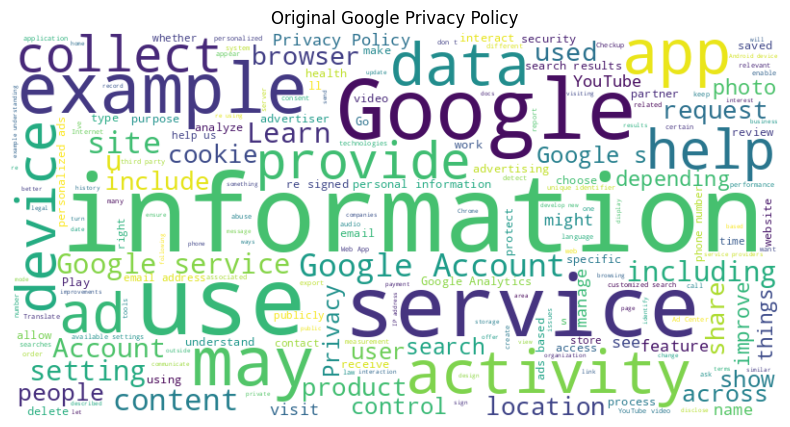

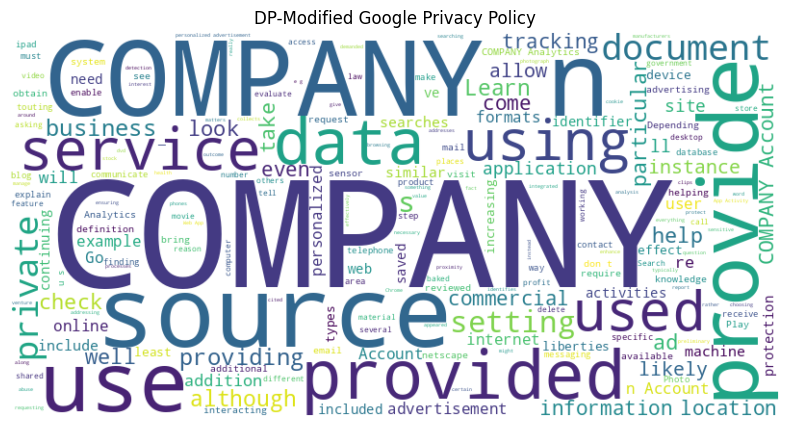

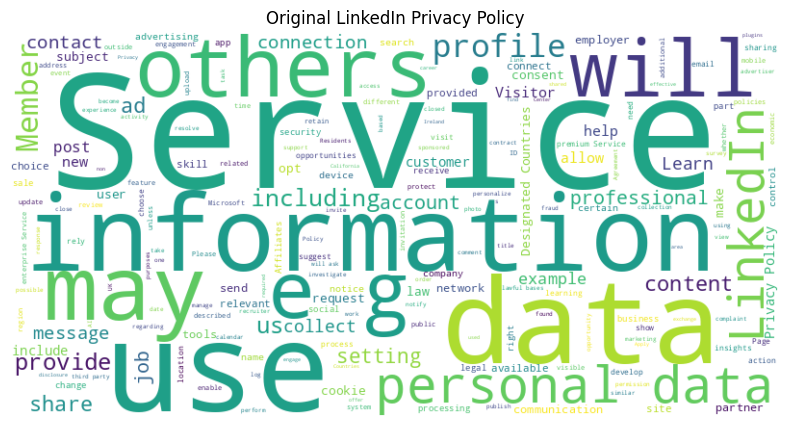

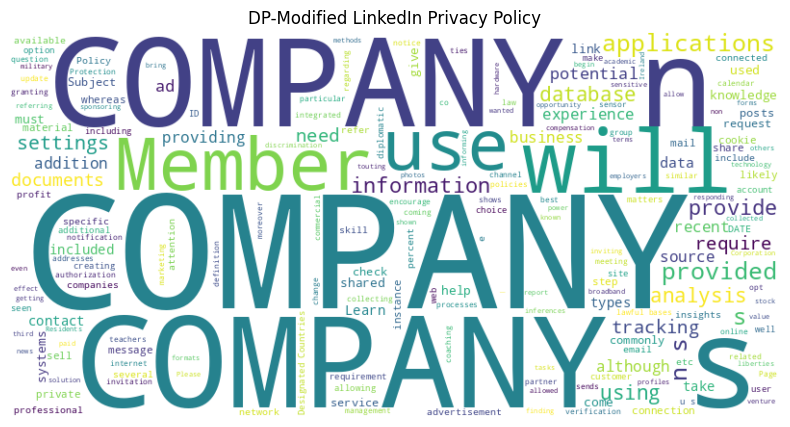

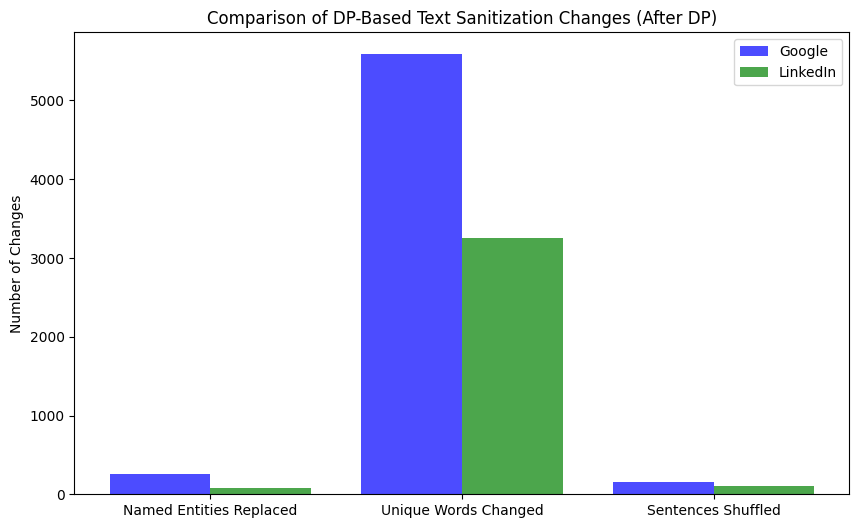

In [ ]:
import requests
import re
import numpy as np
import nltk
import spacy
import gensim.downloader as api
import matplotlib.pyplot as plt
import networkx as nx
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud
from collections import Counter

# Download necessary resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")  # Load spaCy model for Named Entity Recognition (NER)
stopwords = set(nltk.corpus.stopwords.words("english"))  # Load stopwords

# Load Word2Vec Model for Semantic Similarity
word_vectors = api.load("glove-wiki-gigaword-50")  # Use GloVe embeddings

# Step 1: Extract Privacy Policies
def extract_privacy_policy(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    paragraphs = soup.find_all("p")
    policy_text = " ".join([p.get_text() for p in paragraphs])
    return policy_text if policy_text else "Privacy Policy text not found."

# URLs for Google and LinkedIn Privacy Policies
google_privacy_policy_url = "https://policies.google.com/privacy"
linkedin_privacy_policy_url = "https://www.linkedin.com/legal/privacy-policy"

# Fetch policies
google_text = extract_privacy_policy(google_privacy_policy_url)
linkedin_text = extract_privacy_policy(linkedin_privacy_policy_url)

# Step 2: DP-Based Text Sanitization Functions
def replace_named_entities(text):
    doc = nlp(text)
    modified_text = text
    entity_replacements = []
    for ent in doc.ents:
        if ent.label_ in ["ORG", "GPE"]:
            modified_text = modified_text.replace(ent.text, "<COMPANY>")
            entity_replacements.append((ent.text, "<COMPANY>"))
        elif ent.label_ in ["DATE", "TIME", "DURATION"]:
            modified_text = modified_text.replace(ent.text, "<DATE>")
            entity_replacements.append((ent.text, "<DATE>"))
    return modified_text, entity_replacements

def get_filtered_similar_words(word, k=5, similarity_threshold=0.75):
    try:
        similar_words = word_vectors.most_similar(word, topn=k)
        filtered_words = [w[0] for w in similar_words if w[1] >= similarity_threshold]
        return filtered_words if filtered_words else [word]
    except KeyError:
        return [word]

def dp_word_substitute(text, epsilon=1.0, k=5, similarity_threshold=0.75):
    words = word_tokenize(text)
    new_words = []
    word_changes = []

    for word in words:
        if word.lower() in stopwords:
            new_words.append(word)
            continue
        candidates = get_filtered_similar_words(word, k, similarity_threshold)
        if len(candidates) > 1:
            scores = np.array([word_vectors.similarity(word, w) for w in candidates])
            probabilities = np.exp(epsilon * scores) / np.sum(np.exp(epsilon * scores))
            replacement = np.random.choice(candidates, p=probabilities)
            if replacement != word:
                word_changes.append((word, replacement))
            new_words.append(replacement)
        else:
            new_words.append(word)
    return " ".join(new_words), word_changes

def shuffle_sentences(text, epsilon=0.5):
    sentences = sent_tokenize(text)
    noise = np.random.laplace(0, 1/epsilon, len(sentences))
    shuffled_sentences = [x for _, x in sorted(zip(noise, sentences))]
    sentence_changes = list(zip(sentences, shuffled_sentences))
    return " ".join(shuffled_sentences), sentence_changes

def add_laplace_noise(text, epsilon=0.5):
    def replace_number(match):
        number = int(match.group(0))
        noise = np.random.laplace(0, 1/epsilon)
        noisy_number = max(1, int(number + noise))
        return str(noisy_number)
    modified_text = re.sub(r"\b\d+\b", replace_number, text)
    return modified_text

# Apply DP-Based Transformations
google_sanitized, google_entity_changes = replace_named_entities(google_text)
google_sanitized, google_word_changes = dp_word_substitute(google_sanitized, epsilon=1.0, k=5, similarity_threshold=0.75)
google_sanitized, google_sentence_changes = shuffle_sentences(google_sanitized, epsilon=0.5)
google_sanitized = add_laplace_noise(google_sanitized, epsilon=0.5)

linkedin_sanitized, linkedin_entity_changes = replace_named_entities(linkedin_text)
linkedin_sanitized, linkedin_word_changes = dp_word_substitute(linkedin_sanitized, epsilon=1.0, k=5, similarity_threshold=0.75)
linkedin_sanitized, linkedin_sentence_changes = shuffle_sentences(linkedin_sanitized, epsilon=0.5)
linkedin_sanitized = add_laplace_noise(linkedin_sanitized, epsilon=0.5)

# Step 3: Word Cloud Comparison (Before & After)
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

generate_wordcloud(google_text, "Original Google Privacy Policy")
generate_wordcloud(google_sanitized, "DP-Modified Google Privacy Policy")
generate_wordcloud(linkedin_text, "Original LinkedIn Privacy Policy")
generate_wordcloud(linkedin_sanitized, "DP-Modified LinkedIn Privacy Policy")

# Step 4: Bar Chart After Sanitization (Comparison)
categories = ["Named Entities Replaced", "Unique Words Changed", "Sentences Shuffled"]
google_changes = [len(google_entity_changes), len(google_word_changes), len(google_sentence_changes)]
linkedin_changes = [len(linkedin_entity_changes), len(linkedin_word_changes), len(linkedin_sentence_changes)]

plt.figure(figsize=(10, 6))
x = range(len(categories))
plt.bar(x, google_changes, width=0.4, label="Google", alpha=0.7, color='blue')
plt.bar([i + 0.4 for i in x], linkedin_changes, width=0.4, label="LinkedIn", alpha=0.7, color='green')
plt.xticks([i + 0.2 for i in x], categories)
plt.ylabel("Number of Changes")
plt.title("Comparison of DP-Based Text Sanitization Changes (After DP)")
plt.legend()
plt.show()



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu



=== Sentiment Analysis Scores ===
Google (Before DP): 0.9270
Google (After DP): 0.9486
LinkedIn (Before DP): 0.9242
LinkedIn (After DP): 0.9515


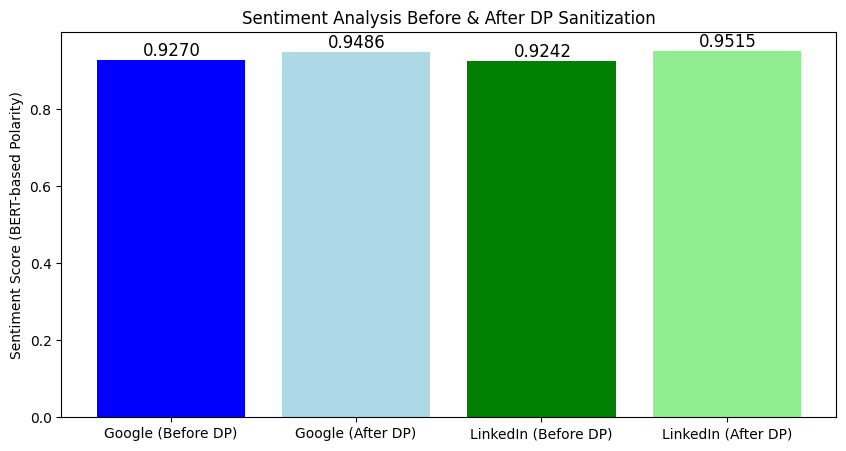

In [ ]:
import requests
import re
import numpy as np
import nltk
import spacy
import gensim.downloader as api
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud
from collections import Counter
from transformers import pipeline  # BERT-based sentiment analysis

# Download necessary resources
nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")  # Load spaCy model for Named Entity Recognition (NER)
stopwords = set(nltk.corpus.stopwords.words("english"))  # Load stopwords

# Load Word2Vec Model for Semantic Similarity
word_vectors = api.load("glove-wiki-gigaword-50")  # Use GloVe embeddings

# Step 1: Extract Privacy Policies
def extract_privacy_policy(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    paragraphs = soup.find_all("p")
    policy_text = " ".join([p.get_text() for p in paragraphs])
    return policy_text if policy_text else "Privacy Policy text not found."

# URLs for Google and LinkedIn Privacy Policies
google_privacy_policy_url = "https://policies.google.com/privacy"
linkedin_privacy_policy_url = "https://www.linkedin.com/legal/privacy-policy"

# Fetch policies
google_text = extract_privacy_policy(google_privacy_policy_url)
linkedin_text = extract_privacy_policy(linkedin_privacy_policy_url)

# Step 2: DP-Based Text Sanitization Functions
def replace_named_entities(text):
    doc = nlp(text)
    modified_text = text
    entity_replacements = []
    for ent in doc.ents:
        if ent.label_ in ["ORG", "GPE"]:
            modified_text = modified_text.replace(ent.text, "<COMPANY>")
            entity_replacements.append((ent.text, "<COMPANY>"))
        elif ent.label_ in ["DATE", "TIME", "DURATION"]:
            modified_text = modified_text.replace(ent.text, "<DATE>")
            entity_replacements.append((ent.text, "<DATE>"))
    return modified_text, entity_replacements

def get_filtered_similar_words(word, k=5, similarity_threshold=0.75):
    try:
        similar_words = word_vectors.most_similar(word, topn=k)
        filtered_words = [w[0] for w in similar_words if w[1] >= similarity_threshold]
        return filtered_words if filtered_words else [word]
    except KeyError:
        return [word]

def dp_word_substitute(text, epsilon=1.0, k=5, similarity_threshold=0.75):
    words = word_tokenize(text)
    new_words = []
    word_changes = []

    for word in words:
        if word.lower() in stopwords:
            new_words.append(word)
            continue
        candidates = get_filtered_similar_words(word, k, similarity_threshold)
        if len(candidates) > 1:
            scores = np.array([word_vectors.similarity(word, w) for w in candidates])
            probabilities = np.exp(epsilon * scores) / np.sum(np.exp(epsilon * scores))
            replacement = np.random.choice(candidates, p=probabilities)
            if replacement != word:
                word_changes.append((word, replacement))
            new_words.append(replacement)
        else:
            new_words.append(word)
    return " ".join(new_words), word_changes

def shuffle_sentences(text, epsilon=0.5):
    sentences = sent_tokenize(text)
    noise = np.random.laplace(0, 1/epsilon, len(sentences))
    shuffled_sentences = [x for _, x in sorted(zip(noise, sentences))]
    sentence_changes = list(zip(sentences, shuffled_sentences))
    return " ".join(shuffled_sentences), sentence_changes

def add_laplace_noise(text, epsilon=0.5):
    def replace_number(match):
        number = int(match.group(0))
        noise = np.random.laplace(0, 1/epsilon)
        noisy_number = max(1, int(number + noise))
        return str(noisy_number)
    modified_text = re.sub(r"\b\d+\b", replace_number, text)
    return modified_text

# Apply DP-Based Transformations
google_sanitized, google_entity_changes = replace_named_entities(google_text)
google_sanitized, google_word_changes = dp_word_substitute(google_sanitized, epsilon=1.0, k=5, similarity_threshold=0.75)
google_sanitized, google_sentence_changes = shuffle_sentences(google_sanitized, epsilon=0.5)
google_sanitized = add_laplace_noise(google_sanitized, epsilon=0.5)

linkedin_sanitized, linkedin_entity_changes = replace_named_entities(linkedin_text)
linkedin_sanitized, linkedin_word_changes = dp_word_substitute(linkedin_sanitized, epsilon=1.0, k=5, similarity_threshold=0.75)
linkedin_sanitized, linkedin_sentence_changes = shuffle_sentences(linkedin_sanitized, epsilon=0.5)
linkedin_sanitized = add_laplace_noise(linkedin_sanitized, epsilon=0.5)

# Step 3: BERT-Based Sentiment Analysis (Sentence-Level)
sentiment_analyzer = pipeline("sentiment-analysis")

def calculate_sentiment(text):
    sentences = sent_tokenize(text)
    sentiment_scores = [sentiment_analyzer(sentence)[0]['score'] for sentence in sentences]
    return np.mean(sentiment_scores)

# Compute Sentiment Scores for Google & LinkedIn Privacy Policies
google_sentiment_before = calculate_sentiment(google_text)
google_sentiment_after = calculate_sentiment(google_sanitized)
linkedin_sentiment_before = calculate_sentiment(linkedin_text)
linkedin_sentiment_after = calculate_sentiment(linkedin_sanitized)

# Print Exact Sentiment Scores
print("\n=== Sentiment Analysis Scores ===")
print(f"Google (Before DP): {google_sentiment_before:.4f}")
print(f"Google (After DP): {google_sentiment_after:.4f}")
print(f"LinkedIn (Before DP): {linkedin_sentiment_before:.4f}")
print(f"LinkedIn (After DP): {linkedin_sentiment_after:.4f}")

# Step 4: Visualize Sentiment Score Changes with Exact Values
labels = ["Google (Before DP)", "Google (After DP)", "LinkedIn (Before DP)", "LinkedIn (After DP)"]
sentiment_scores = [google_sentiment_before, google_sentiment_after, linkedin_sentiment_before, linkedin_sentiment_after]

plt.figure(figsize=(10, 5))
bars = plt.bar(labels, sentiment_scores, color=["blue", "lightblue", "green", "lightgreen"])
plt.ylabel("Sentiment Score (BERT-based Polarity)")
plt.title("Sentiment Analysis Before & After DP Sanitization")

# Annotate bars with exact sentiment values
for bar, score in zip(bars, sentiment_scores):
    plt.text(bar.get_x() + bar.get_width()/2 - 0.15, bar.get_height() + 0.01, f"{score:.4f}", fontsize=12)

plt.show()


In [2]:
import requests
import re
import numpy as np
import nltk
import spacy
import gensim.downloader as api
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud
from collections import Counter
from transformers import pipeline

# Download necessary resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm')
stopwords = set(nltk.corpus.stopwords.words('english'))

# Load Word2Vec Model for Semantic Similarity
word_vectors = api.load('glove-wiki-gigaword-50')

# Step 1: Extract Privacy Policies
def extract_privacy_policy(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    paragraphs = soup.find_all('p')
    policy_text = ' '.join([p.get_text() for p in paragraphs])
    return policy_text if policy_text else 'Privacy Policy text not found.'

# Example URLs
google_privacy_policy_url = 'https://policies.google.com/privacy'
linkedin_privacy_policy_url = 'https://www.linkedin.com/legal/privacy-policy'

# Fetch policies
google_text = extract_privacy_policy(google_privacy_policy_url)
linkedin_text = extract_privacy_policy(linkedin_privacy_policy_url)

# CusText-inspired Techniques
def create_custom_output_set(word, k=5, similarity_threshold=0.75):
    try:
        similar_words = word_vectors.most_similar(word, topn=k)
        filtered_words = [w[0] for w in similar_words if w[1] >= similarity_threshold]
        return filtered_words if filtered_words else [word]
    except KeyError:
        return [word]

def exponential_mechanism(word, candidates, epsilon=1.0):
    if len(candidates) == 1:
        return candidates[0]
    scores = np.array([word_vectors.similarity(word, w) for w in candidates])
    probabilities = np.exp(epsilon * scores) / np.sum(np.exp(epsilon * scores))
    return np.random.choice(candidates, p=probabilities)

def dp_word_substitute_custext(text, epsilon=1.0, k=5, similarity_threshold=0.75):
    words = word_tokenize(text)
    new_words = []
    word_changes = []
    for word in words:
        if word.lower() in stopwords:
            new_words.append(word)
            continue
        candidates = create_custom_output_set(word, k, similarity_threshold)
        replacement = exponential_mechanism(word, candidates, epsilon)
        if replacement != word:
            word_changes.append((word, replacement))
        new_words.append(replacement)
    return ' '.join(new_words), word_changes

# Apply the Enhanced Technique
google_sanitized, google_word_changes = dp_word_substitute_custext(google_text, epsilon=1.0, k=5, similarity_threshold=0.75)

# Example Output
print('Original Text (Sample):', google_text[:500])
print('\nSanitized Text (Sample):', google_sanitized[:500])
print('\nWord Changes:', google_word_changes[:10])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Original Text (Sample): When you use our services, you’re trusting us with your information. We understand this is a big responsibility and work hard to protect your information and put you in control. This Privacy Policy is meant to help you understand what information we collect, why we collect it, and how you can update, manage, export, and delete your information. Privacy Checkup Looking to change your privacy settings? Take the Privacy Checkup We build a range of services that help millions of people daily to expl

Sanitized Text (Sample): When you or our private also you [ re trusting u.s. with your documents it We why this is a coming committed and working even to protecting your sources and keep you in power this This Privacy Policy is make to helping you how what data we check with why we obtain it . and how you can updated . help . exporting with and deletes your provided , Privacy Checkup Looking to should your protections settings n't Take the Privacy Checkup We plans a hig